Pontificia Universidad Católica de Chile <br>
Departamento de Ciencia de la Computación <br>
2025 - Bimestre 3 <br>


<h1><center> Procesamiento de Lenguaje Natural

Tarea 1: Hate Speech Detection </center></h1>
        **Profesor**: Marcelo Mendoza<br>
Fecha de entrega: 17/08/2025 23:59

---

# Librerías

In [ ]:
#Incorpore las librerías en esta sección
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import warnings
import re
# Configuración de estilo de Seaborn
warnings.filterwarnings("ignore")
plt.style.use('ggplot')

## NLTK
import nltk
nltk.download('stopwords', quiet=True) ## Descarga de los stopwords
nltk.download('wordnet', quiet=True) ## Lematizador para reducción de palabras
nltk.download('omw-1.4', quiet=True) ## diccionario de sinónimos y antónimos

from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

## Algoritmo de ML & TF-IDF Vectorizer & Metricas
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

### Evaluación del modelo
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# Introducción y Explicación General del problema

El conjunto de datos utilizado en este estudio se construyó a partir de tweets obtenidos a través de la API de Twitter y filtrados utilizando un léxico de discurso de odio proporcionado por Hatebase.org. Inicialmente, se identificaron y recopilaron tweets que contenían términos específicos catalogados como discurso de odio por la comunidad. Este proceso resultó en una muestra de 85.4 millones de tweets, provenientes de 33,458 usuarios de Twitter.

Posteriormente, se realizó una selección aleatoria de tweets de esta muestra inicial para su análisis detallado. Estos tweets fueron evaluados manualmente por trabajadores de CrowdFlower (CF), quienes clasificaron cada tweet en una de tres categorías: discurso de odio, lenguaje ofensivo pero no discurso de odio, y ni ofensivo ni discurso de odio.

**Estructura del dataset**

Para el desarrollo de la tarea, se deben concentrar en dos columnas:

* tweet: Contiene la oración que debe ser evaluada.
* label: Clasificación asociada a cada sentencia de la variable tweet.

Respecto a la variable label, se tiene la siguiente codificación:

* 0 - discurso de odio
* 1 - lenguaje ofensivo
* 2 - ninguno

El conjunto de datos ya está divido en train (df_train) y test (df_test)

# 1. Descripción del conjunto de datos

In [ ]:
# A continuación, se presenta el código para cargar los conjuntos de train y test
# Se supone que los conjuntos df_train.csv y df_test.csv ya están subidos en el entorno de google colab
df_train = pd.read_csv('df_train.csv', encoding='utf-8')
df_test = pd.read_csv('df_test.csv', encoding='utf-8')

## 0. Revisión del dataset

In [3]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19826 entries, 0 to 19825
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Unnamed: 0          19826 non-null  int64 
 1   count               19826 non-null  int64 
 2   hate_speech         19826 non-null  int64 
 3   offensive_language  19826 non-null  int64 
 4   neither             19826 non-null  int64 
 5   label               19826 non-null  int64 
 6   tweet               19826 non-null  object
dtypes: int64(6), object(1)
memory usage: 1.1+ MB


In [4]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19826 entries, 0 to 19825
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Unnamed: 0          19826 non-null  int64 
 1   count               19826 non-null  int64 
 2   hate_speech         19826 non-null  int64 
 3   offensive_language  19826 non-null  int64 
 4   neither             19826 non-null  int64 
 5   label               19826 non-null  int64 
 6   tweet               19826 non-null  object
dtypes: int64(6), object(1)
memory usage: 1.1+ MB


## 1.1 Gráfica de dataset de entrenamiento 

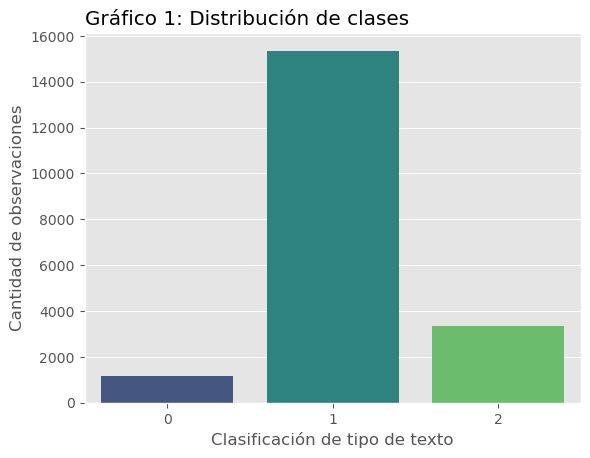

In [5]:
cantidad_registros = df_train['label'].value_counts()

### Gráfico de barras :
sns.barplot(x=cantidad_registros.index, y=cantidad_registros.values, palette='viridis')
plt.xlabel('Clasificación de tipo de texto')
plt.ylabel('Cantidad de observaciones')
plt.title('Gráfico 1: Distribución de clases', loc='left')
plt.show();

**Notas** 
---
 * Se observa que existe una clase mayoritaría asociada a uso de lenguaje ofensivo. Por lo tanto, para un uso de un modelo, se requerirá utilizan un modelo que pueda gestionar de manera adecuada clases minoritarias y/o utilizar métodos de re-balanceo de clases

## 1.2  Calculo del tamaño (longitud) de las frases según tipo de discurso

In [6]:
### Cálculo del número de palabras por tweet

def calculo_palabras(tweet):

    ''''
    Esta función separa las palabras de un tweet contando cuantas palabras existen en él. Se toma en cuenta para separar los espacios.
    Parámetros:
        tweet: string, cadena de texto que contiene cada tweet.
    Retorna:
       num_palabras: int, número de palabras que contiene cada tweet.
    '''
    return len(tweet.split())

df_train['num_palabras'] = df_train['tweet'].apply(calculo_palabras)

df_train[['label','tweet', 'num_palabras']]

,label,tweet,num_palabras
0,1,Talking Angela is a hoe,5
1,1,Lol they tricking niccas left n right,7
2,1,&#128514;&#128514; bitches get stuff done. htt...,6
3,1,@ArtaleGaspare bitch i got the flameeee,6
4,1,@vivaalakatyy @brotherbill7 @JHuff_5 good bitc...,6
...,...,...,...
19821,2,RT @RayIopez: When you're approaching your hig...,17
19822,1,@skyereyes_ @keanabermudez YOOOOOOOOOOOOOO LMF...,15
19823,2,RT @KelsieBelsi: @Vntxnius lmao it will have a...,11
19824,1,"Y'all hoes broke, be stealing from the mall bu...",11


In [7]:
### Análisis estadístico descriptivo del número de palabras por tweet:
df_train.groupby('label')['num_palabras'].describe()

,count,mean,std,min,25%,50%,75%,max
label,,,,,,,,
0,1144.0,13.808566,7.021095,1.0,8.0,13.0,20.0,32.0
1,15352.0,13.969450,6.804982,1.0,9.0,13.0,19.0,33.0
2,3330.0,14.930330,6.760145,1.0,9.0,15.0,20.0,32.0


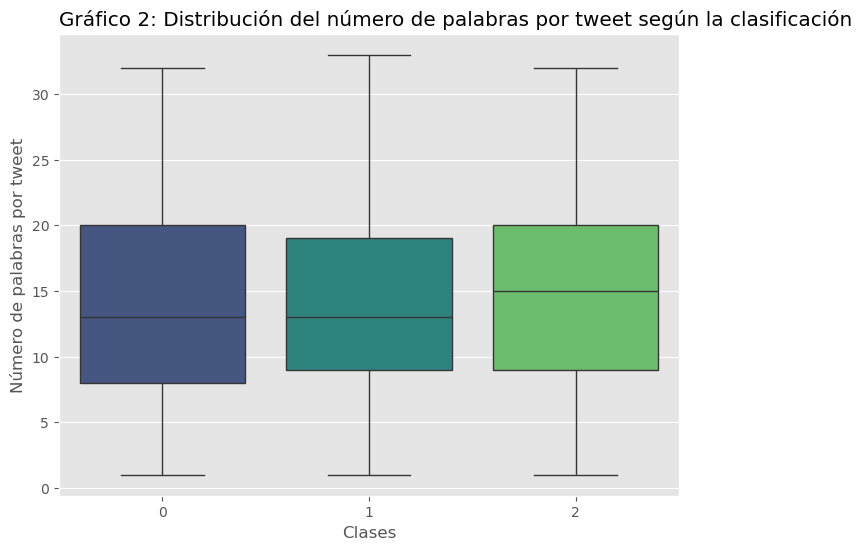

In [8]:
### Gráfico boxplot del número de palabras por tweet según la clasificación:
plt.figure(figsize=(8, 6))
sns.boxplot(x='label', y='num_palabras', data=df_train, palette='viridis')
plt.xlabel('Clases')
plt.ylabel('Número de palabras por tweet')
plt.title('Gráfico 2: Distribución del número de palabras por tweet según la clasificación', loc ='left')
plt.show();

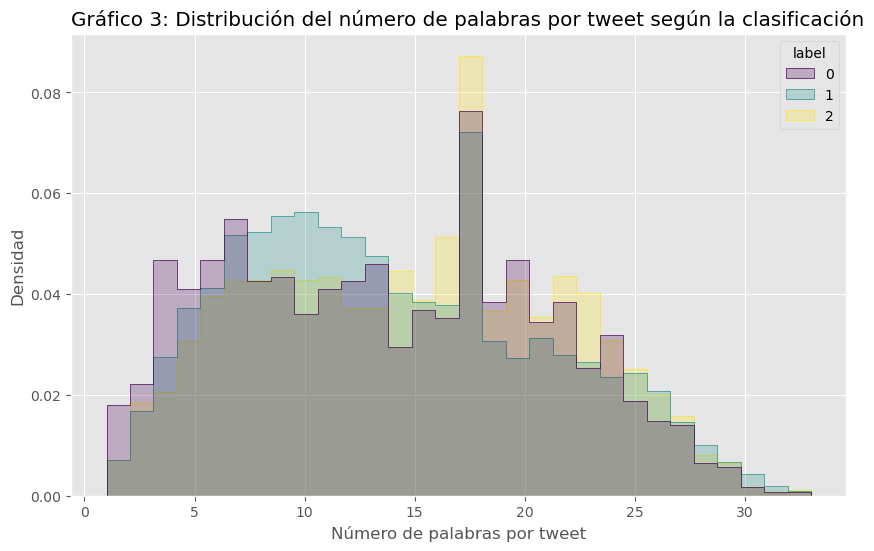

In [9]:
### Distribución del número de palabras por tweet según la clasificación:
plt.figure(figsize=(10, 6))
sns.histplot(data=df_train, x='num_palabras', hue='label', element='step', stat='density', common_norm=False, palette='viridis', bins=30)
plt.xlabel('Número de palabras por tweet')
plt.ylabel('Densidad')
plt.title('Gráfico 3: Distribución del número de palabras por tweet según la clasificación', loc='left')
plt.show();

**Observaciones**
---

* Para el caso de tweet con discurso de odio y uso de lenguaje ofensivo (clase 0 y 1) respectivamente, se observa en su distribución la mediana de palabras por tweet coinciden, un valor de 13. Ahora bien, se observa que los tweets con uso de discurso de odio podrían llegar a ser más extenso (más palabras por tweet) frente a los que pertenecen a la clase 1 (uso de lenguaje ofensivo).

* Respecto a los tweet's pertecencientes a las clase 2, presentan un rango inter-cualtil similar a la clase 1, con una mediana un poco superior a superior de palabras (15 palabras por tweet). Por lo tanto, podrían ser un poco más extensos

## 1.3 Palabras más frecuentes por cada una de las clases

In [10]:
# 1. Definición de función para obtener las palabras más frecuentes por clase
def palabras_frecuentes_por_clase(df, clase, n):
    '''
    Esta función obtiene las palabras más frecuentes de un tweet por clase.
    Parámetros:
        df: DataFrame, conjunto de datos que contiene los tweets y sus respectivas clases.
        clase: int, número de la clase para la cual se desea obtener las palabras más frecuentes.
        n: int, número de palabras más frecuentes a retornar.
    Retorna:
        palabras_frecuentes: Series, las n palabras más frecuentes en la clase especificada.
    '''
    tweets_clase = df[df['label'] == clase]['tweet']
    todas_palabras = ' '.join(tweets_clase)
    palabras = todas_palabras.split()
    conteo_palabras = pd.Series(palabras).value_counts().head(n)
    return conteo_palabras

# 2. DF con las palabras más frecuentes por cada clase :

palabras_clase_0 = palabras_frecuentes_por_clase(df_train, 0, n=40)
palabras_clase_1 = palabras_frecuentes_por_clase(df_train, 1, n=40)
palabras_clase_2 = palabras_frecuentes_por_clase(df_train, 2, n=40)

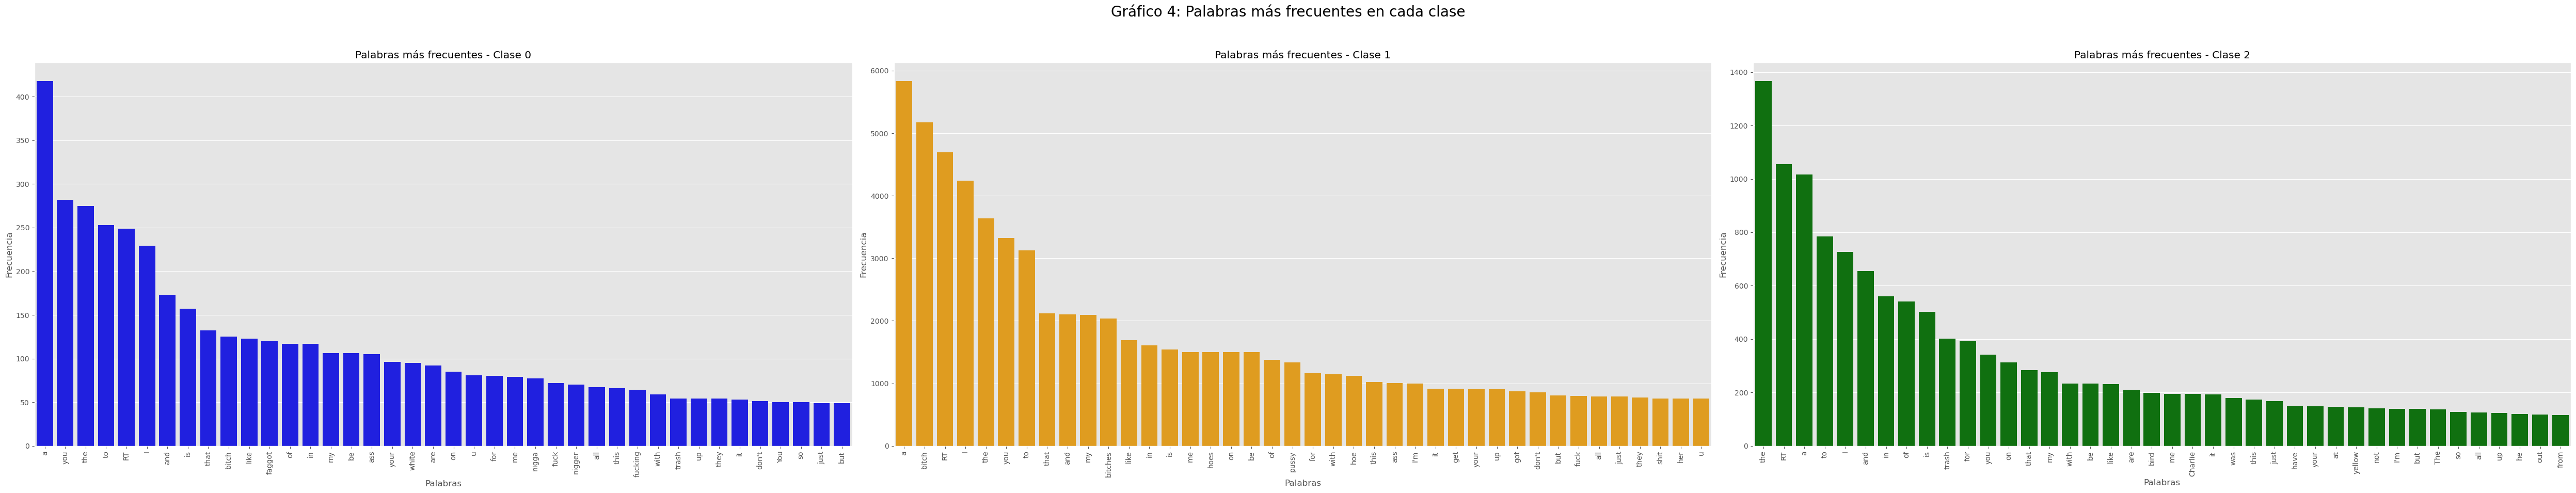

In [11]:
### Graficar las palabras más frecuentes por clase con un gráfico de barras

fig, ax = plt.subplots(1,3, figsize = (50,10))

sns.barplot(x=palabras_clase_0.index, y=palabras_clase_0.values, ax=ax[0], color='blue')
sns.barplot(x=palabras_clase_1.index, y=palabras_clase_1.values, ax=ax[1], color='orange')
sns.barplot(x=palabras_clase_2.index, y=palabras_clase_2.values, ax=ax[2], color='green')

for a in ax:
    a.set_xticklabels(a.get_xticklabels(), rotation=90) 

### Títulos y etiquetas
ax[0].set_title('Palabras más frecuentes - Clase 0')
ax[0].set_xlabel('Palabras')
ax[0].set_ylabel('Frecuencia') 

ax[1].set_title('Palabras más frecuentes - Clase 1')
ax[1].set_xlabel('Palabras')
ax[1].set_ylabel('Frecuencia') 

ax[2].set_title('Palabras más frecuentes - Clase 2')
ax[2].set_xlabel('Palabras')
ax[2].set_ylabel('Frecuencia') 

### Titulo General

plt.suptitle('Gráfico 4: Palabras más frecuentes en cada clase', fontsize=20)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])  
plt.show();


**Nota**:
---

* En las tres clases de tipo de tweet's se observa la presencia de stop words los cuales agredarán dimensionalidad al problema de clasificación.
* Existen otras expresiones propias de la plataforma como lo son `'RT'` y algunos caracteres especiales como `'@'`que permiten vincular alguna persona que también deberían eliminarse el pre-procesamiento del texto 

#  2. Preprocesamiento de texto

Decisiones : 
---

1. Se eliminarán palabras cortas 2 o menos caracteres, esto permitirá eliminar los RT, que son significativos cerca 5710 tweet's contienen este acrónimo.
2. Se eliminarán caracteres especiales que son muy frecuentes en los tweet's, como lo es `@`, `#`. Esto es relevante ya que, el algortimo reconocería por ejemplo `#angry`, `angry` como una palabra diferente, siendo que son la misma.
3. Se eliminarán otras expresiones que contengan `hppt://` es decir, que hagan referencia a una página web, programa de televisión etc.
4. Se eliminarán caracteres númericos, que para este contexto sólo aumentarán la dimensionalidad del problema, no aportando un valor adicional
5. Naturalmente, se eliminarán los stopwords, ya que en las gráficas anteriores se observan que no aportarán mayor contexto adicional para que el algoritmo pueda aprender.


In [12]:
df_train['tweet'].str.contains('RT').value_counts()

tweet
False    14116
True      5710
Name: count, dtype: int64

In [13]:
df_train['tweet'].str.contains('#').value_counts()

tweet
False    13745
True      6081
Name: count, dtype: int64

Implementación:
---

* Se aplicarán las decisiones anteriormente comentadas tanto para el set de train y test

In [14]:
## Limpieza de los tweets quitar hppt y números:

def limpieza_tweet(tweet):
    '''
    Esta función limpia los tweets eliminando caracteres especiales, números y URLs.
    Parámetros:
        tweet: string, cadena de texto que contiene el tweet.
    Retorna:
        tweet_limpio: string, tweet limpio sin caracteres especiales ni números.
    '''
    # Eliminar URLs
    tweet = re.sub(r'http\S+|www\S+|https\S+', '', tweet, flags=re.MULTILINE)
    # Eliminar números
    tweet = re.sub(r'\d+', '', tweet)
    # Eliminar caracteres especiales
    tweet = re.sub(r'[^\w\s]', '', tweet)
    return tweet.strip()

df_train['tweet_limpio'] = df_train['tweet'].apply(limpieza_tweet)
df_test['tweet_limpio'] = df_test['tweet'].apply(limpieza_tweet)

### Print ejemplo de tweets limpios
df_train[['label','tweet', 'tweet_limpio']].head(10)

,label,tweet,tweet_limpio
0,1,Talking Angela is a hoe,Talking Angela is a hoe
1,1,Lol they tricking niccas left n right,Lol they tricking niccas left n right
2,1,&#128514;&#128514; bitches get stuff done. htt...,bitches get stuff done
3,1,@ArtaleGaspare bitch i got the flameeee,ArtaleGaspare bitch i got the flameeee
4,1,@vivaalakatyy @brotherbill7 @JHuff_5 good bitc...,vivaalakatyy brotherbill JHuff_ good bitch choke
5,1,I like saying the word pussy hoe ion no why!!!,I like saying the word pussy hoe ion no why
6,1,This bitch forehead. Hairline. Who lied to her...,This bitch forehead Hairline Who lied to her a...
7,1,@mingtong007 you still are a cunt,mingtong you still are a cunt
8,1,I feel bad for her nicca tho ... Ya girl a hoe...,I feel bad for her nicca tho Ya girl a hoe my...
9,2,Log off nigger RT @PoloKingBC: #relationshipgo...,Log off nigger RT PoloKingBC relationshipgoals


In [15]:
# Definición de tokenizer, stop_words y lemmatizer
tokenizer = RegexpTokenizer(r'\w+') ## Sólo considera palabras con caracteres alfanúmericos (se implementa la decisión 1)
stop_words = set(stopwords.words('english')) ## Se eliminarán las palabras no significativas
lemmatizer = WordNetLemmatizer() ## Se utilizará el lematizador para reducir las palabras a su raíz

def tokenizacion (tweet):
    text_in = "" if tweet is None else str(tweet)
    tokens = tokenizer.tokenize(text_in)

    ## Se implementan las decisiones 2, 3 y 4

    tokens = [t.lower() for t in tokens if len(t) > 2 and t.lower() not in stop_words]  ## Se eliminan las palabras no significativas y se convierten a

    ## Lematización:
    lemmas = [lemmatizer.lemmatize(t) for t in tokens]
    
    return " ".join(lemmas)

In [16]:
## Aplicación de la función de tokenización a los tweets
df_train['tweet_corregido'] = df_train['tweet_limpio'].apply(tokenizacion)
df_test['tweet_corregido'] = df_test['tweet_limpio'].apply(tokenizacion)

In [17]:
df_train[['label','tweet', 'tweet_corregido']].head(10)

,label,tweet,tweet_corregido
0,1,Talking Angela is a hoe,talking angela hoe
1,1,Lol they tricking niccas left n right,lol tricking niccas left right
2,1,&#128514;&#128514; bitches get stuff done. htt...,bitch get stuff done
3,1,@ArtaleGaspare bitch i got the flameeee,artalegaspare bitch got flameeee
4,1,@vivaalakatyy @brotherbill7 @JHuff_5 good bitc...,vivaalakatyy brotherbill jhuff_ good bitch choke
5,1,I like saying the word pussy hoe ion no why!!!,like saying word pussy hoe ion
6,1,This bitch forehead. Hairline. Who lied to her...,bitch forehead hairline lied amp approved shit
7,1,@mingtong007 you still are a cunt,mingtong still cunt
8,1,I feel bad for her nicca tho ... Ya girl a hoe...,feel bad nicca tho girl hoe nicca
9,2,Log off nigger RT @PoloKingBC: #relationshipgo...,log nigger polokingbc relationshipgoals


# 3. Entrenar clasificador con TF-IDF (embedding Ingenuo)

In [18]:
## Vectorización de los tweets corregidos :

vectorizador = TfidfVectorizer()

vector_train = vectorizador.fit_transform(df_train['tweet_corregido'])
vector_test = vectorizador.transform(df_test['tweet_corregido'])

### Dimensiones del vector

print(f"Dimensiones del vector de entrenamiento: {vector_train.shape}")
print(f"Dimensiones del vector de prueba: {vector_test.shape}")

Dimensiones del vector de entrenamiento: (19826, 27063)
Dimensiones del vector de prueba: (4957, 27063)


# 4. Entrenamiento y Elección de Algoritmo de clasificación

In [ ]:
### Evaluación de una serie de modelos de clasificación para 3 clases :

dict_modelos = {
    'Regresión Logística': LogisticRegression(random_state=42),
    'SGD': SGDClassifier(random_state=42),
    'SVM': SVC(random_state=42),
    'Árbol de Decisión': DecisionTreeClassifier(random_state=42),
    'Bosque Aleatorio': RandomForestClassifier(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42)
}

resultados = {}
for nombre, modelo in dict_modelos.items():
    
    ### Entrenamiento del modelo :
    modelo.fit(vector_train, df_train['label'])

    ### Evaluación del modelo :

    accuracy = accuracy_score(df_train['label'], modelo.predict(vector_train))
    precision = precision_score(df_train['label'], modelo.predict(vector_train), average='weighted')
    recall = recall_score(df_train['label'], modelo.predict(vector_train), average='weighted')
    f1 = f1_score(df_train['label'], modelo.predict(vector_train), average='weighted')

    ## almacenamiento de los resultados en un diccionario
    score = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1
    }
    
    resultados[nombre] = score

### Resultados a DataFrame
resultados_df = pd.DataFrame(resultados.items(), columns=['Modelo', 'Score'])

In [20]:
resultados_df

,Modelo,Score
0,Regresión Logística,"{'Accuracy': 0.9445677393321901, 'Precision': ..."
1,SGD,"{'Accuracy': 0.9387168364773529, 'Precision': ..."
2,SVM,"{'Accuracy': 0.974477958236659, 'Precision': 0..."
3,Árbol de Decisión,"{'Accuracy': 0.9994956118228588, 'Precision': ..."
4,Bosque Aleatorio,"{'Accuracy': 0.9994451730051448, 'Precision': ..."
5,Gradient Boosting,"{'Accuracy': 0.893120145263795, 'Precision': 0..."


In [21]:
### Entrenamiento del modelo

clasificador = SGDClassifier(loss="loss_log", penalty="l2", alpha=1e-3, random_state=42, class_weight='balanced')

clasificador = RandomForestClassifier(random_state=42)
clasificador = clasificador.fit(vector_train, df_train.label)
clasificador.score(vector_test, df_test.label)

0.8965099858785556

# 5. Revisión de Metricas por clase

In [22]:
Y_predict = clasificador.predict(vector_test)
print(classification_report(df_test.label, Y_predict))

              precision    recall  f1-score   support

           0       0.62      0.14      0.23       286
           1       0.91      0.97      0.94      3838
           2       0.86      0.81      0.83       833

    accuracy                           0.90      4957
   macro avg       0.80      0.64      0.67      4957
weighted avg       0.88      0.90      0.88      4957



**Observaciones y Resultados:**
---

* Se observa que el modelo en el conjunto de prueba logra generalizar de buena manera los tweet's con lenguaje ofensivo. Esto se observa debido a su 91\% de aquellas que se clasificaron como dicha clase, lo eran (clasifica pocos como falsos positivos). Adicionalmente, para lo que respecta al recall, también se observa que el modelo generaliza de buena manera para esta clase.

* Para la clase 2, es decir aquellos tweet's neutros se observa que el modelo logra poder clasificar de manera adecuada a esto.

* Por contraposición, para lo que respecta a la clase 0, podemos observar que el modelo no logra generalizar de buena manera, ya que, vemos un ratio importante de falsos positivos, así como nivel bajo de racall, por lo cual el modelo no es óptimo para clasificar discursos de odio.

* El punto anterior podría darse a que los discursos de odio contienen muchas palabras que están presentes en los tweet's que pertenecen a clase de lenguaje ofensivo. Esta superposición hace que sea necesario tener más ejemplos.



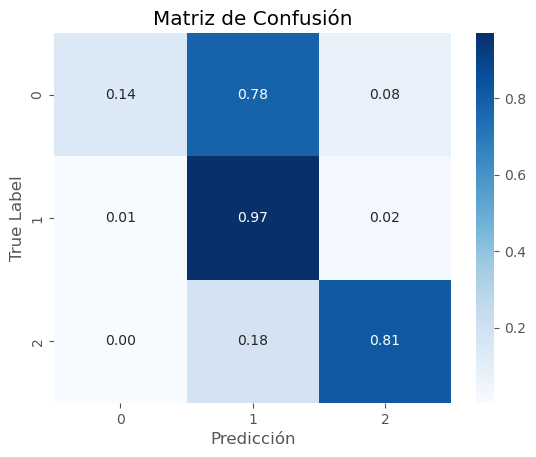

In [23]:
matriz_confusion = confusion_matrix(df_test.label, Y_predict)
matriz_confusion_norm = matriz_confusion.astype('float') / matriz_confusion.sum(axis=1)[:, np.newaxis]

sns.heatmap(matriz_confusion_norm, annot=True, fmt='.2f', cmap='Blues')
plt.xlabel('Predicción')
plt.ylabel('True Label')
plt.title('Matriz de Confusión')
plt.show();

**Conclusiones Finales**
---





* Como se pudo observar los tweet's que pertenecen a la clase 0 y 1, tienen una mediana similar en términos de extensión (cuantas palabras) se hacen uso dentro de un tweet.

* Adicionalmente, tanto los discursos de odio como tweet con lenguaje ofensivo tienen una serie de palabras en común, lo que hace que para el algoritmo sea bien dificil generalizar y, en definitiva por clasificar de manera adecuada. Esto se observa para el conjunto de test, un 78% de las observaciones de la clase 0 son clasificadas como con uso de lenguaje ofensivo, y tan solo 14% pertenecen a la clase 0.

* En lo que respecta a las clase 2, tan solo un 18% de los casos no pueden ser correctamente clasificados, siendo clasificados en la clase 1. Esto se puede deber a uso de algunas palabras que pudieran estar muy directamente relacionadas con la clase 1. Esto deja entrever que el modelo no logra comprender el contexto de uso de una palabra, es decir, las palabras polisemicas no pueden ser capturadas de manera adecuada.

* Así mismo el hecho de contar con tan pocos ejemplos de discursos de odio hace que el modelo no pueda establecer una generalización adecuada de las expresiones de los usuarios en los tweet's. 

* Para mejorar la tarea de clasificación sería ideal contar con más ejemplos asociados a la clase 0, para que la proporción no sea tan baja. Adicionalmente, es relevante el uso de embeddings contextuales y modelos de lenguaje que realmente puedan diferenciar y relacionar las palabras vía un contexto